In [1]:
 pip install grpcio

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: grpcio in c:\users\sande\anaconda3\lib\site-packages (1.34.1)



In [2]:
pip install tensorflow==2.5.0


Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install bert-for-tf2

In [4]:
!pip install sentencepiece

In [5]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

C:\Users\sande\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\sande\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\sande\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [6]:
train=pd.read_csv("train.csv")
valid=pd.read_csv("valid.csv")
test=pd.read_csv("test.csv")

In [7]:
train = pd.concat([train, valid]).reset_index(drop=True)

In [8]:
train.head()

,text,intent
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [9]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")
bert_ckpt_file = bert_ckpt_file.replace("\\", "/")

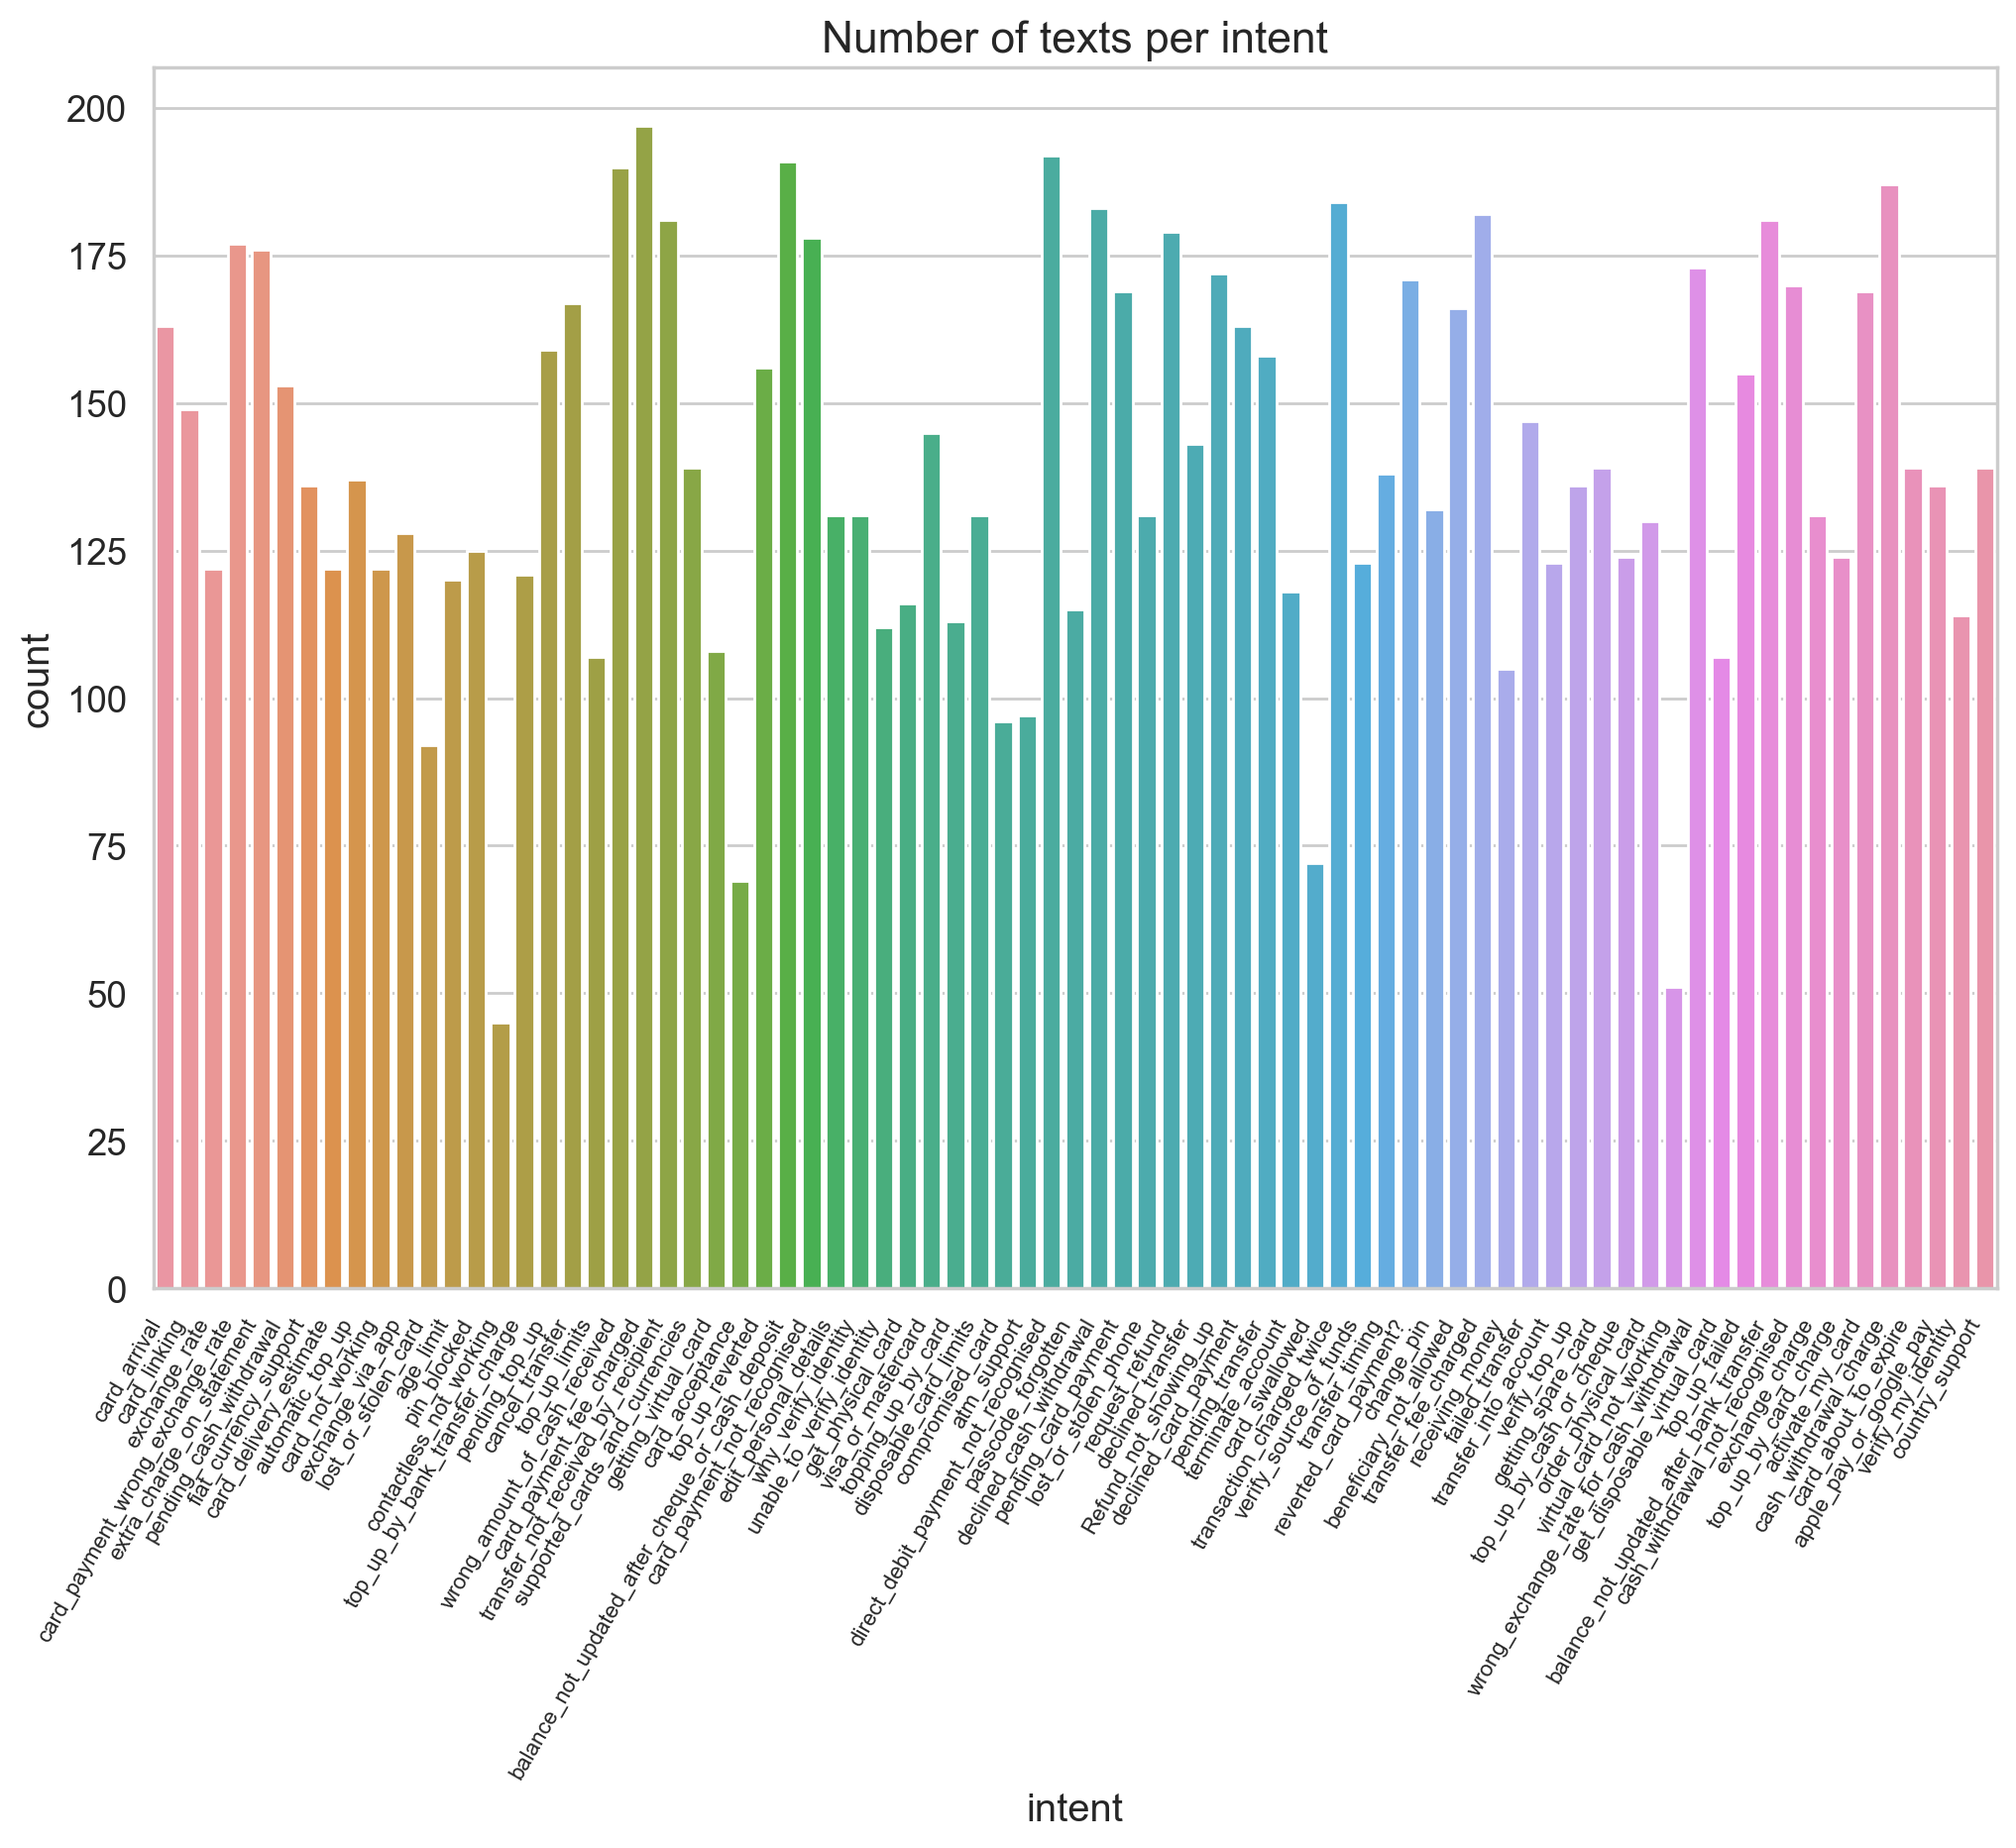

<Figure size 8000x4800 with 0 Axes>

In [10]:
# chart = sns.countplot(data=train, x='intent')
# plt.title("Number of texts per intent")
# chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='right')
# plt.show()

chart = sns.countplot(data=train, x='intent')

# Set the title
plt.title("Number of texts per intent", fontsize=16)

# Rotate and align the x-axis tick labels
chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='right', fontsize=8)

# Increase the figure size
plt.figure(figsize=(80, 48))  # Adjust the width and height as desired

# Adjust the spacing
plt.tight_layout()

# Display the plot
plt.show()

In [11]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=512):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes

    train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])

    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []

    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [12]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [13]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model


In [14]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=512)

10773it [00:02, 4978.04it/s]
C:\Users\sande\AppData\Local\Temp\ipykernel_4504\2555760654.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(x), np.array(y)
3080it [00:00, 5609.02it/s]


max seq_len 98


In [15]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 98, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x0000019AB06EBDC0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [16]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [17]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M")

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5


C:\Users\sande\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


606/606 [==============================] - 3432s 6s/step - loss: 4.1218 - acc: 0.0785 - val_loss: 2.9267 - val_acc: 0.3052
Epoch 2/5
606/606 [==============================] - 3419s 6s/step - loss: 1.8118 - acc: 0.5682 - val_loss: 1.6575 - val_acc: 0.5547
Epoch 3/5
606/606 [==============================] - 3422s 6s/step - loss: 0.8952 - acc: 0.8002 - val_loss: 1.3831 - val_acc: 0.6048
Epoch 4/5
606/606 [==============================] - 3408s 6s/step - loss: 0.5756 - acc: 0.8699 - val_loss: 1.3390 - val_acc: 0.6345
Epoch 5/5
606/606 [==============================] - 3418s 6s/step - loss: 0.4104 - acc: 0.9068 - val_loss: 1.1877 - val_acc: 0.6698


In [18]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

97/97 [==============================] - 323s 3s/step - loss: 0.3664 - acc: 0.9016
train acc 0.9319595098495483
test acc 0.9016233682632446


In [19]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [20]:
print(classification_report(data.test_y, y_pred, target_names=classes))

                                                  precision    recall  f1-score   support

                                    card_arrival       0.90      0.90      0.90        40
                                    card_linking       1.00      0.93      0.96        40
                                   exchange_rate       0.91      0.97      0.94        40
                card_payment_wrong_exchange_rate       0.93      0.93      0.93        40
                       extra_charge_on_statement       1.00      0.95      0.97        40
                         pending_cash_withdrawal       0.97      0.82      0.89        40
                           fiat_currency_support       0.87      0.85      0.86        40
                          card_delivery_estimate       0.88      0.95      0.92        40
                                automatic_top_up       1.00      0.90      0.95        40
                                card_not_working       0.87      0.97      0.92        40
         

In [21]:
# # Save the model using model.save()
model.save("TrainedModelBert123")

# # Save the model as a TensorFlow SavedModel
 tf.saved_model.save(model, "TrainedModelBert_saved_model123")


IndentationError: unexpected indent (1570759360.py, line 5)

In [22]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)


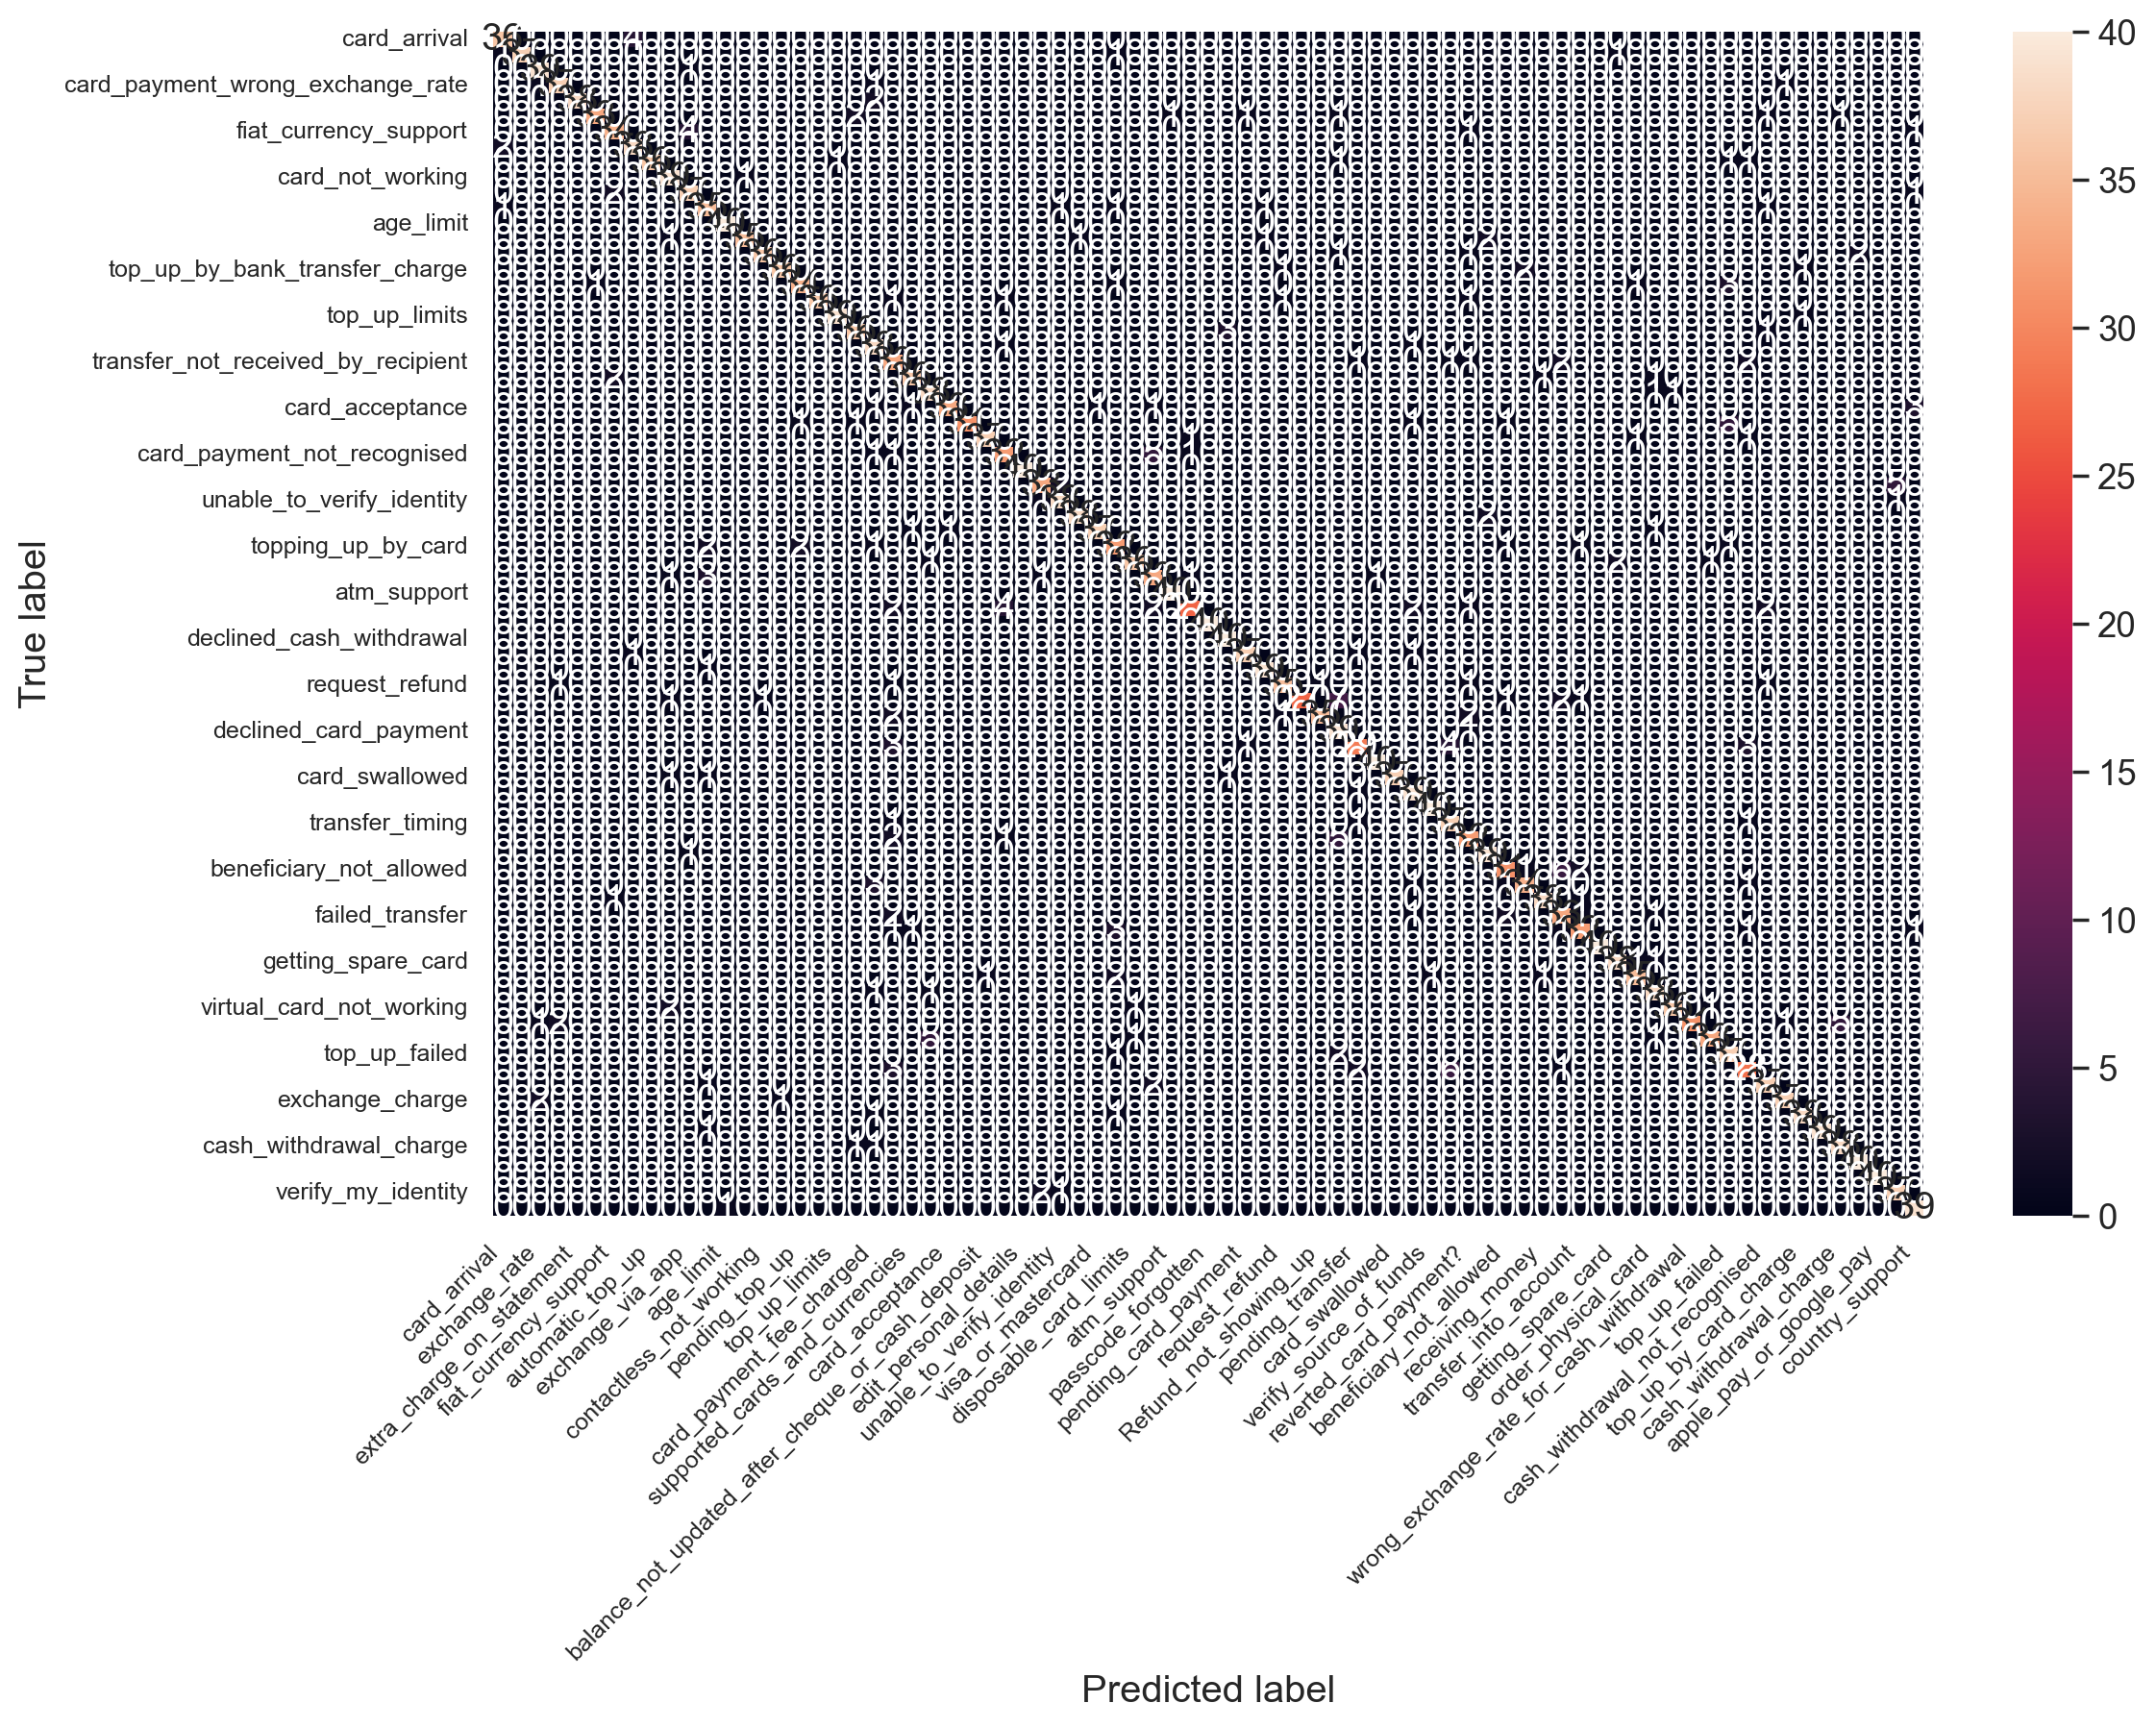

In [28]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=9)
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=9)
plt.ylabel('True label')
plt.xlabel('Predicted label');


In [24]:
sentences = [
  "Do you know if there is a tracking number for the new card you sent me?",
  "How do I link to my credit card with you?"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: Do you know if there is a tracking number for the new card you sent me? 
intent: card_arrival

text: How do I link to my credit card with you? 
intent: topping_up_by_card



In [25]:
print(data.max_seq_len)

98
